# **Prediction of English Language Proficiency Assessments for California (ELPAC) Scores Using Machine Learning Approach**

### **TEAM MEMBERS: TEAM 3:  EMMA OO, LUKE AWINO, OSCAR GIL**

### **Applied Data Science Master’s Program, Shiley Marcos School of Engineering / University of San Diego**

**DATE:  11/28/2022**

In [117]:
#load packages
import pandas as pd
import numpy as np
import datetime
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#modeling packages
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import tree
import warnings 
warnings.filterwarnings(action= 'ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### **Import files from Excel file containing ELPAC results**

In [ ]:
#path to the dataset
ELPAC_file_path = '/Users/oscargil/Desktop/ADS-599B/Raw_Files/ELPAC.xlsx'
# Import ELPAC data into dataframes
elpac1718 = pd.read_excel(open(ELPAC_file_path, 'rb'), sheet_name='2017-2018', dtype=str)
# Drop identified columns
elpac1718.drop(elpac1718.columns[[0, 1, 5, 7, 8, 9, 10]], axis=1, inplace=True)

In [ ]:
# Import ELPAC data into dataframes
elpac1819 = pd.read_excel(open(ELPAC_file_path, 'rb'), sheet_name='2018-2019', dtype=str)
# Drop identified columns
elpac1819.drop(elpac1819.columns[[0, 1, 5, 7, 8, 9, 10]], axis=1, inplace=True)

In [ ]:
# Import ELPAC data into dataframes
elpac1920 = pd.read_excel(open(ELPAC_file_path, 'rb'), sheet_name='2019-2020', dtype=str)
# Drop identified columns
elpac1920.drop(elpac1920.columns[[0, 1, 5, 7, 8, 9, 10]], axis=1, inplace=True)

In [ ]:
# Import ELPAC data into dataframes
elpac2021 = pd.read_excel(open(ELPAC_file_path, 'rb'), sheet_name='2020-2021', dtype=str)
# Drop identified columns
elpac2021.drop(elpac2021.columns[[0, 1, 6, 8, 9, 10, 11]], axis=1, inplace=True)

In [ ]:
# Import ELPAC data into dataframes
elpac2122 = pd.read_excel(open(ELPAC_file_path, 'rb'), sheet_name='2021-2022', dtype=str)
# Remove 44 results associated to the Alternative ELPAC
elpac2122 = elpac2122.query("RecordType == '21'")

# Drop identified columns
elpac2122.drop(elpac2122.columns[[1, 5, 7, 8, 9, 17, 19, 21, 54, 55, 56, 57, 58, 61, 62, 63, 64, 70, 71, 72, 73, 79, 80, 81, 82, 88, 89, 90, 91, 97, 98, 99, 100]], axis=1, inplace=True)

#### **Create a unique list of all SSIDs and assign them the Pandas Dataframe index number as their de-identified number**

In [ ]:
# Create data frame of SSIDs to de-identify
ssids = pd.DataFrame(pd.concat([elpac1718.elpac_2018_ssid, elpac1819.elpac_2019_ssid, elpac1920.elpac_2020_ssid, elpac2021.elpac_2021_ssid, elpac2122.SSID], axis=0))
# Unique SSID values
ssid_deidentify = pd.DataFrame(ssids[0].unique())
ssid_deidentify.columns = ['SSID']
# Assign Data frame index as de-identified ID
ssid_deidentify['Stu_deID'] =  ssid_deidentify.index

In [ ]:
# Create local file to have as reference to Stu_deID
ssid_deidentify.to_csv('/Users/oscargil/Desktop/ADS-599B/Raw_Files/ssid_deidentify.csv', encoding='utf-8', index=False)

#### **Merge de-identified ID into ELPAC dataframes, then dropped the SSID field containing the real values**

In [ ]:
# Merge in de-identier
elpac1718 = elpac1718.merge(ssid_deidentify, how="inner", left_on='elpac_2018_ssid', right_on='SSID')
# Drop SSID columns
elpac1718.drop(elpac1718.columns[[3, 57]], axis=1, inplace=True)

In [ ]:
# Merge in de-identier
elpac1819 = elpac1819.merge(ssid_deidentify, how="inner", left_on='elpac_2019_ssid', right_on='SSID')
# Drop SSID columns
elpac1819.drop(elpac1819.columns[[3, 54]], axis=1, inplace=True)

In [ ]:
# Merge in de-identier
elpac1920 = elpac1920.merge(ssid_deidentify, how="inner", left_on='elpac_2020_ssid', right_on='SSID')
# Drop SSID columns
elpac1920.drop(elpac1920.columns[[3, 79]], axis=1, inplace=True)

In [ ]:
# Merge in de-identier
elpac2021 = elpac2021.merge(ssid_deidentify, how="inner", left_on='elpac_2021_ssid', right_on='SSID')
# Drop SSID columns
elpac2021.drop(elpac2021.columns[[4, 120]], axis=1, inplace=True)

In [ ]:
# Merge in de-identier
elpac2122 = elpac2122.merge(ssid_deidentify, how="inner", left_on='SSID', right_on='SSID')
# Drop SSID columns
elpac2122.drop(elpac2122.columns[[3]], axis=1, inplace=True)

#### **Add AcademicYear column to each ELPAC file, to join into attendance files**

In [ ]:
# Add AcademicYear column
elpac1718['AcademicYear'] = '2017-2018'
elpac1819['AcademicYear'] = '2018-2019'
elpac1920['AcademicYear'] = '2019-2020'
elpac2021['AcademicYear'] = '2020-2021'
elpac2122['AcademicYear'] = '2021-2022'

#### **Identify features to keep from ELPAC files**

In [ ]:
# Subset ELPAC files
elpac1718 = elpac1718.iloc[:,[56, 57, 3, 4, 7, 10, 11]]
elpac1819 = elpac1819.iloc[:,[53, 54, 3, 4, 7, 10, 11]]
elpac1920 = elpac1920.iloc[:,[78, 79, 3, 6, 7, 8, 9]]
elpac2021 = elpac2021.iloc[:,[119, 120, 4, 5, 8, 9, 10]]
elpac2122 = elpac2122[['Stu_deID', 'AcademicYear','DateofBirth', 'CALPADSGrade', 'FinalTestCompletedDate', 'OverallScaleScore', 'OverallPL']]

# Rename columns
elpac_columns = ['Stu_deID', 'AcademicYear', 'DOB', 'GradeLevel', 'TestDate', 'OverallScore', 'OverallLevel']

elpac1718.columns = elpac_columns
elpac1819.columns = elpac_columns
elpac1920.columns = elpac_columns
elpac2021.columns = elpac_columns
elpac2122.columns = elpac_columns

In [ ]:
# Data conversions - DOB to datetime
elpac1718['DOB'] = pd.to_datetime(elpac1718['DOB'])
elpac1819['DOB'] = pd.to_datetime(elpac1819['DOB'])
elpac1920['DOB'] = pd.to_datetime(elpac1920['DOB'])
elpac2021['DOB'] = pd.to_datetime(elpac2021['DOB'])
elpac2122['DOB'] = pd.to_datetime(elpac2122['DOB'])

In [ ]:
# Data conversions - TestDate to datetime
elpac1718['TestDate'] = pd.to_datetime(elpac1718['TestDate'])
elpac1819['TestDate'] = pd.to_datetime(elpac1819['TestDate'])
elpac1920['TestDate'] = pd.to_datetime(elpac1920['TestDate'])
elpac2021['TestDate'] = pd.to_datetime(elpac2021['TestDate'])
elpac2122['TestDate'] = pd.to_datetime(elpac2122['TestDate'])

In [ ]:
# Data conversions - GradeLevel clean up, eliminate extra zero, convert KN to 0
elpac1718['GradeLevel'] = elpac1718.GradeLevel.replace('KN', '0').astype(int)
elpac1819['GradeLevel'] = elpac1819.GradeLevel.replace('KN', '0').astype(int)
elpac1920['GradeLevel'] = elpac1920.GradeLevel.replace('KN', '0').astype(int)
elpac2021['GradeLevel'] = elpac2021.GradeLevel.replace('KN', '0').astype(int)
elpac2122['GradeLevel'] = elpac2122.GradeLevel.replace('KN', '0').astype(int)

In [ ]:
elpac1718['OverallScore'] = elpac1718.OverallScore.replace('NS',0).fillna(0).astype(int)
elpac1819['OverallScore'] = elpac1819.OverallScore.replace('NS',0).fillna(0).astype(int)
elpac1920['OverallScore'] = elpac1920.OverallScore.replace('NS',0).fillna(0).astype(int)
elpac2021['OverallScore'] = elpac2021.OverallScore.replace('NS',0).fillna(0).astype(int)
elpac2122['OverallScore'] = elpac2122.OverallScore.replace('NS',0).fillna(0).astype(int)

elpac1718['OverallLevel'] = elpac1718.OverallLevel.replace('NS',0).fillna(0).astype(int)
elpac1819['OverallLevel'] = elpac1819.OverallLevel.replace('NS',0).fillna(0).astype(int)
elpac1920['OverallLevel'] = elpac1920.OverallLevel.replace('NS',0).fillna(0).astype(int)
elpac2021['OverallLevel'] = elpac2021.OverallLevel.replace('NS',0).fillna(0).astype(int)
elpac2122['OverallLevel'] = elpac2122.OverallLevel.replace('NS',0).fillna(0).astype(int)

In [ ]:
# Update Elpac file containing all years
elpac = pd.concat([elpac1718, elpac1819, elpac1920, elpac2021, elpac2122], axis=0)

#### **Feature Engineering Ideas**

* Day of the week
* Grade Level + percentage of days enrolled (so for example, 4th grade would not be represented by a '4', instead, by '4.80' - a 4th grader who attended 80% of the time)
* Number of Levels a student progressed from previous ELPAC (17-18 a student who scores a Level 1, then in 18-19 scoed a Level 3; the student progressed 2 levels)
* Age of Student at time of test
* Teacher information (years teaching)
* Total in Household
* Household income
* Homeless

In [ ]:
# Feature Engineering
# TestDayName
elpac['TestDayName'] = elpac.TestDate.dt.day_name()

In [ ]:
# Age at time of test
elpac['TestAge'] = (elpac.TestDate - elpac.DOB) / np.timedelta64(1, 'Y')

In [ ]:
elpac

### **Attendance Files**

In [ ]:
Attendance_file_path = '/Users/oscargil/Desktop/ADS-599B/Raw_Files/'

In [ ]:
# Load attendance data
att_1718 = pd.read_csv(Attendance_file_path + 'STAS_ODS_1718.txt', sep='^', dtype=str, header=None)
att_1819 = pd.read_csv(Attendance_file_path + 'STAS_ODS_1819.txt', sep='^', dtype=str, header=None)
att_1920 = pd.read_csv(Attendance_file_path + 'STAS_ODS_1920.txt', sep='^', dtype=str, header=None)
att_2021 = pd.read_csv(Attendance_file_path + 'STAS_ODS_2021.txt', sep='^', dtype=str, header=None)
att_2122 = pd.read_csv(Attendance_file_path + 'STAS_ODS_2122.txt', sep='^', dtype=str, header=None)

In [ ]:
# columns to keep
att_1718 = att_1718.iloc[:,[5, 6, 14, 15]].fillna(0.00)
att_1819 = att_1819.iloc[:,[5, 6, 14, 15]].fillna(0.00)
att_1920 = att_1920.iloc[:,[5, 6, 14, 15]].fillna(0.00)
att_2021 = att_2021.iloc[:,[5, 6, 14, 15]].fillna(0.00)
att_2122 = att_2122.iloc[:,[5, 6, 14, 15]].fillna(0.00)

In [ ]:
# Assign column names
att_columns = ['AcademicYear', 'SSID', 'ExpectedAttendanceDays', 'DaysAttended']

att_1718.columns = att_columns
att_1819.columns = att_columns
att_1920.columns = att_columns
att_2021.columns = att_columns
att_2122.columns = att_columns

In [ ]:
# Data conversions
att_1718['ExpectedAttendanceDays'] = att_1718.ExpectedAttendanceDays.astype(float)
att_1819['ExpectedAttendanceDays'] = att_1819.ExpectedAttendanceDays.astype(float)
att_1920['ExpectedAttendanceDays'] = att_1920.ExpectedAttendanceDays.astype(float)
att_2021['ExpectedAttendanceDays'] = att_2021.ExpectedAttendanceDays.astype(float)
att_2122['ExpectedAttendanceDays'] = att_2122.ExpectedAttendanceDays.astype(float)

In [ ]:
# Data conversions
att_1718['DaysAttended'] = att_1718.DaysAttended.astype(float)
att_1819['DaysAttended'] = att_1819.DaysAttended.astype(float)
att_1920['DaysAttended'] = att_1920.DaysAttended.astype(float)
att_2021['DaysAttended'] = att_2021.DaysAttended.astype(float)
att_2122['DaysAttended'] = att_2122.DaysAttended.astype(float)

In [ ]:
# Att into one file
att = pd.concat([att_1718, att_1819, att_1920, att_2021, att_2122], axis =0)

### **Student demographics and Teacher data**

In [ ]:
# Informaation from SQL query in Data Server with file name "CAPSTONE SQL code.sql"
teacher_stuDemographics = pd.read_csv('/Users/oscargil/Desktop/ADS-599B/Raw_Files/teacher_stuDemographics.csv', dtype=str)

In [ ]:
# Unique Schoolname values - only present in the 2021-2022 file
schools_deidentify = pd.DataFrame(teacher_stuDemographics.SchoolName.unique())

schools_deidentify.columns = ['SchoolName']

# Assign Data frame index as de-identified ID
schools_deidentify['School_deID'] =  schools_deidentify.index

# Merge in de-identier
teacher_stuDemographics = teacher_stuDemographics.merge(schools_deidentify, how="inner", left_on='SchoolName', right_on='SchoolName')

# Drop school name column
teacher_stuDemographics.drop(teacher_stuDemographics.columns[[2]], axis=1, inplace=True)

# Create local file to have as reference to School_deID
schools_deidentify.to_csv('/Users/oscargil/Desktop/ADS-599B/Raw_Files/schools_deidentify.csv', encoding='utf-8', index=False)


In [ ]:
# Incorporate deidentified student ID
teacher_stuDemographics = teacher_stuDemographics.merge(ssid_deidentify, how="inner", left_on='SSID', right_on='SSID')

# Drop student ID column
teacher_stuDemographics.drop(teacher_stuDemographics.columns[[1]], axis=1, inplace=True)

In [ ]:
# Update elpac dataframe
elpac = elpac.merge(teacher_stuDemographics, how="inner", left_on=('AcademicYear', 'Stu_deID'), right_on=('AcademicYear', 'Stu_deID'))

### **Data transformation and Feauture Engineering Using SQLite**

In [ ]:
cnn = sqlite3.connect('/Users/oscargil/Desktop/ADS-599B/Raw_Files/db.db')

In [ ]:
# Load dataframes into sql
att.to_sql("att", cnn, if_exists='replace')
ssid_deidentify.to_sql("ssid", cnn, if_exists='replace')

In [ ]:
%load_ext sql

In [ ]:
%sql sqlite:////Users/oscargil/Desktop/ADS-599B/Raw_Files/db.db

In [ ]:
%%sql

select s.Stu_deID, AcademicYear, sum(ExpectedAttendanceDays) as ExpectedAttendanceDays, sum(DaysAttended) as DaysAttended
, sum(DaysAttended) / sum(ExpectedAttendanceDays) as AttendedPct
, sum(ExpectedAttendanceDays) / 180.0 as EnrolledPct
from att as a 
join ssid as s 
    on a.SSID = s.SSID
group by a.SSID, a.AcademicYear
limit 10

In [ ]:
# SQL results to dataframe
att_sql = '''
select s.Stu_deID, AcademicYear, sum(ExpectedAttendanceDays) as ExpectedAttendanceDays, sum(DaysAttended) as DaysAttended
, sum(DaysAttended) / sum(ExpectedAttendanceDays) as AttendedPct
, sum(ExpectedAttendanceDays) / 180.0 as EnrolledPct
from att as a 
join ssid as s 
    on a.SSID = s.SSID
group by a.SSID, a.AcademicYear
'''

att_df = pd.read_sql_query(att_sql, cnn)

In [ ]:
# Merge attendance into ELPAC file
elpac = elpac.merge(att_df, how='inner', left_on=('Stu_deID', 'AcademicYear'), right_on=('Stu_deID', 'AcademicYear'))

In [ ]:
# Feature Engineering
elpac['GradeEnrolledPct'] = elpac.GradeLevel + elpac.EnrolledPct.replace(1.0,.999999)

elpac['GradeAttendedPct'] = elpac.GradeLevel + elpac.AttendedPct.replace(1.0,.999999)

#### **Sort columns for final output**

In [ ]:
elpac = elpac.iloc[:,[1, 0, 17, 3, 2, 8, 9, 10, 11, 12, 13, 7, 4, 5, 6, 18, 19, 20, 21, 22, 23, 15, 14, 16]]

#### **Export ELPAC file to CSV**

In [ ]:
#save the file as csv for eda
elpac.to_csv('/Users/oscargil/Desktop/ADS-599B/Data Folder/elpac.csv', encoding='utf-8', index=False)

#### **Exploratory Data Analysis -EDA**

In [50]:
# Import file
df = pd.read_csv('https://raw.githubusercontent.com/OscarG-DataSci/ADS-599B/main/Data%20Folder/elpac.csv')
#load the file
df.head()

,AcademicYear,Stu_deID,School_deID,GradeLevel,DOB,TestAge,StudentGender,StudentEthnicity,Special_Education,Homeless,SocioEconomically,TestDayName,TestDate,OverallScore,OverallLevel,ExpectedAttendanceDays,DaysAttended,AttendedPct,EnrolledPct,GradeEnrolledPct,GradeAttendedPct,TeacherGender,TeacherTotalYearsOfService,TeacherEthnicity
0,2017-2018,0,3,1,2011-07-04,6.828340,F,Hispanic,N,Y,Y,Wednesday,2018-05-02,1503,4,180.0,175.0,0.972222,1.0,1.999999,1.972222,F,4,Hispanic
1,2017-2018,1,5,4,2008-07-28,9.631957,M,Hispanic,N,N,Y,Friday,2018-03-16,1535,3,180.0,168.0,0.933333,1.0,4.999999,4.933333,F,2,Multiple
2,2017-2018,3,3,4,2008-05-06,9.905748,M,Hispanic,Y,N,N,Monday,2018-04-02,1480,2,180.0,175.0,0.972222,1.0,4.999999,4.972222,F,18,White
3,2017-2018,4,3,0,2012-04-13,6.108271,M,Hispanic,N,N,Y,Wednesday,2018-05-23,1461,4,180.0,125.0,0.694444,1.0,0.999999,0.694444,F,1,White
4,2017-2018,5,7,0,2011-09-25,6.664066,M,Hispanic,N,N,Y,Friday,2018-05-25,1357,1,180.0,165.0,0.916667,1.0,0.999999,0.916667,F,17,Hispanic


In [51]:
#get data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11628 entries, 0 to 11627
Data columns (total 24 columns):
AcademicYear                  11628 non-null object
Stu_deID                      11628 non-null int64
School_deID                   11628 non-null int64
GradeLevel                    11628 non-null int64
DOB                           11628 non-null object
TestAge                       9469 non-null float64
StudentGender                 11628 non-null object
StudentEthnicity              11628 non-null object
Special_Education             11628 non-null object
Homeless                      11628 non-null object
SocioEconomically             11628 non-null object
TestDayName                   9469 non-null object
TestDate                      9469 non-null object
OverallScore                  11628 non-null int64
OverallLevel                  11628 non-null int64
ExpectedAttendanceDays        11628 non-null float64
DaysAttended                  11628 non-null float64
AttendedPct 

In [52]:
# Convert date fields to datetime
df['DOB'] =  pd.to_datetime(df.DOB)
df['TestDate'] =  pd.to_datetime(df.TestDate)
df.head(3)

,AcademicYear,Stu_deID,School_deID,GradeLevel,DOB,TestAge,StudentGender,StudentEthnicity,Special_Education,Homeless,SocioEconomically,TestDayName,TestDate,OverallScore,OverallLevel,ExpectedAttendanceDays,DaysAttended,AttendedPct,EnrolledPct,GradeEnrolledPct,GradeAttendedPct,TeacherGender,TeacherTotalYearsOfService,TeacherEthnicity
0,2017-2018,0,3,1,2011-07-04,6.828340,F,Hispanic,N,Y,Y,Wednesday,2018-05-02,1503,4,180.0,175.0,0.972222,1.0,1.999999,1.972222,F,4,Hispanic
1,2017-2018,1,5,4,2008-07-28,9.631957,M,Hispanic,N,N,Y,Friday,2018-03-16,1535,3,180.0,168.0,0.933333,1.0,4.999999,4.933333,F,2,Multiple
2,2017-2018,3,3,4,2008-05-06,9.905748,M,Hispanic,Y,N,N,Monday,2018-04-02,1480,2,180.0,175.0,0.972222,1.0,4.999999,4.972222,F,18,White


### **CHECK FOR MISSING VALUES, DUPLICATES, AND SCORES WITH ZERO VALUES**

#### **MISSING VALUES**

In [53]:
# Missing data value counts by AcademicYear
# Most missing data is from when the pandemic quarantine went into effect, March, 2020
# The 2020-2021 school year also has many students who did not test due to distance learning, making it difficult to test all students
df[(df.TestDate.isna() == True)]['AcademicYear'].value_counts().sort_index(ascending=False)

2020-2021     858
2019-2020    1255
2018-2019      46
Name: AcademicYear, dtype: int64

In [54]:
# Initial view of shape and missing data
print("Shape: ",df.shape,"\n")
# Columns missing data
df.isnull().sum().to_frame(name='Missing').query('Missing > 0')

Shape:  (11628, 24) 



,Missing
TestAge,2159
TestDayName,2159
TestDate,2159
AttendedPct,3
GradeAttendedPct,3


In [55]:
# Re-load data omitting missing data
df = df[(df.TestDate.isna() == False)]

print("Shape: ",df.shape,"\n")

# Columns missing data
df.isnull().sum().to_frame(name='Missing').query('Missing > 0')


Shape:  (9469, 24) 



,Missing
AttendedPct,2
GradeAttendedPct,2


In [56]:
# Repeat...to verify no more data is missing
df = df[(df.AttendedPct.isna() == False)]
print("Shape: ",df.shape,"\n")
# Columns missing data
df.isnull().sum().to_frame(name='Missing').query('Missing > 0')

Shape:  (9467, 24) 



,Missing


#### **SCORES WITH 0 VALUES**


In [57]:
# omit records where scores are zero
df = df.query("OverallScore != 0")
df.shape

(9460, 24)

#### **DUPLICATES**

In [58]:
#check for duplicated rows in the dataset
duplicated_rows = df[df.duplicated()] 
print("number of duplicate rows: ", duplicated_rows.shape)

number of duplicate rows:  (0, 24)


#### **STANDARDIZATION OF OVERALLSCORE VALUES**
*Since the OverallScore values range differently between grade levels, standardization was performed to obtain the normal distribution.

In [59]:
# View ranges of OverallScore by grade level, to determine if they are all uniform.
df.groupby('GradeLevel').agg({'OverallScore': ['min', 'max']})

OverallScore      
                    min   max
GradeLevel                   
0                  1150  1700
1                  1150  1627
2                  1150  1700
3                  1150  1672
4                  1150  1731
5                  1150  1731
6                  1150  1729

In [60]:
# to Standardize OverallScore values, as the ranges are different between grade levels
grdLevel_describe = []

for g in range(len(pd.DataFrame(df.GradeLevel.unique()))):

    grdLevel_describe.append({'GradeLevel': g,
                             'OverallScoreMin': pd.DataFrame(df.query("GradeLevel == @g").OverallScore.describe().to_list()).iloc[3].values[0],
                             'OverallScoreMax': pd.DataFrame(df.query("GradeLevel == @g").OverallScore.describe().to_list()).iloc[7].values[0]})   

pd.DataFrame(grdLevel_describe) 

,GradeLevel,OverallScoreMin,OverallScoreMax
0,0,1150.0,1700.0
1,1,1150.0,1627.0
2,2,1150.0,1700.0
3,3,1150.0,1672.0
4,4,1150.0,1731.0
5,5,1150.0,1731.0
6,6,1150.0,1729.0


In [61]:
# Bring in min and max columns to df dataframe
df = df.merge(pd.DataFrame(grdLevel_describe) , left_on=('GradeLevel'), right_on=('GradeLevel'))

In [62]:
# Standardize Overall Score
df['OverallScoreStd'] = (df.OverallScore - df.OverallScoreMin) / (df.OverallScoreMax - df.OverallScoreMin)

In [63]:
# Confirm min and max OverallScore standardized values range from 0 to 1 for each grade level
df.groupby('GradeLevel').agg({'OverallScoreStd': ['min', 'max']})

OverallScoreStd     
                       min  max
GradeLevel                     
0                      0.0  1.0
1                      0.0  1.0
2                      0.0  1.0
3                      0.0  1.0
4                      0.0  1.0
5                      0.0  1.0
6                      0.0  1.0

### **Queries of Number of Students with Minimum OverallScore Per Academic Year**


In [64]:
# There are several students who should a result along the zero score line, on scatter plots.
# These are the student counts whose OverallScore equals the minimum score, by AcademicYear
df.query("OverallScore == @df.OverallScoreMin").AcademicYear.value_counts().sort_index()

2017-2018    12
2018-2019    10
2019-2020     3
2020-2021    15
2021-2022     1
Name: AcademicYear, dtype: int64

In [65]:
# Drop columns used for the OverallScoreStd, which are no longer necessary
df = df.drop(['OverallScoreMin', 'OverallScoreMax'], axis=1)
df.shape

(9460, 25)

### **Total ELPAC Assessments; total times the student student has tested**

In [66]:
# Total ELPAC Assessments; total times the student student has tested
total_assessments = df['Stu_deID'].reset_index().groupby( ['Stu_deID'],as_index=False ).count()
total_assessments.columns = ['Stu_deID', 'TotalAssessments']
# Add column TotalAssessments to data frame
df = df.merge(total_assessments, left_on=('Stu_deID'), right_on=('Stu_deID'), how='inner')


### **OverallLevel Growth, from one test instance to the next**


In [67]:
# Capture TestInstance of student assessments, numbering each instance in ascending order, 
# #re-seeding for each student, as opposed to a running number; similar to SQL's RowNum() function
df['TestInstance'] =  df.sort_values(['Stu_deID', 'TestAge'], ascending=True).groupby(['Stu_deID']).cumcount() + 1



In [68]:
# Capture unique TestInstance combinations available in dataframe
TestInstances = []

# the [:-1] ensures that the max number (5) cuts off at 5 for comparison purposes, 
# or else it would be trying to compare with 6, which is non-existent in the dataframe
for i in range(len(df.TestInstance.unique()[:-1])):
  i += 1
  n = i+1

  TestInstances.append({'TestInstanceA': i,
                        'TestInstanceB': n})
  
pd.DataFrame(TestInstances)


,TestInstanceA,TestInstanceB
0,1,2
1,2,3
2,3,4
3,4,5


In [69]:
# Merge test instances into main data frame
df = df.merge(pd.DataFrame(TestInstances), left_on='TestInstance', right_on='TestInstanceA', how='left')


# Create dataframes for instance A and B, respectively
df2a = df[['Stu_deID', 'OverallLevel', 'TestInstanceA']]
df2b = df[['Stu_deID', 'OverallLevel', 'TestInstanceB']]


# Left join dataframes A and B, to align OverallLevels where TestInstances A and B match, yet keep rows where they do not
df2 = df2a.merge(df2b, left_on=('Stu_deID', 'TestInstanceA'), right_on=('Stu_deID', 'TestInstanceB'), how='left')


# Subtract the most recent OverallLevel from previous, to get a Growth result
df2['Growth'] = df2.OverallLevel_x - df2.OverallLevel_y


# Subset the data in preparation to join it back to the main dataframe
df2 = df2[['Stu_deID', 'TestInstanceA', 'Growth']]
df2.columns = ['Stu_deID', 'TestInstance', 'Growth']


# Bring the Growth variable into the main dataframe
df = df.merge(df2, left_index=True, right_index=True, how='left')


# Convert Growth from float to int, filling in with 0 wherever there is data missing
df['Growth'] = df.Growth.fillna(0).astype(int)

# Sort values and reindex
df = df.sort_values(['Stu_deID_x', 'TestInstanceA'], ascending=True, ignore_index=True)

# Subset
df = df.iloc[:,[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 31]]
df.columns = ['AcademicYear', 'Stu_deID', 'School_deID', 'GradeLevel', 'DOB', 'TestAge', 'StudentGender', 'StudentEthnicity'
, 'Special_Education', 'Homeless', 'SocioEconomically', 'TestDayName', 'TestDate', 'OverallScore', 'OverallLevel'
, 'ExpectedAttendanceDays', 'DaysAttended', 'AttendedPct', 'EnrolledPct', 'GradeEnrolledPct', 'GradeAttendedPct'
, 'TeacherGender', 'TeacherTotalYearsOfService', 'TeacherEthnicity', 'OverallScoreStd', 'TotalAssessments', 'TestInstance', 'Growth']

TypeError: sort_values() got an unexpected keyword argument 'ignore_index'

In [ ]:
#plot  Testinstance, overallLevel and growth
pd.crosstab(df.Growth, df.OverallLevel).plot.bar(rot=0)

pd.crosstab(df.TestInstance, df.OverallLevel).plot.bar(rot=0)

pd.crosstab(df.query("TestInstance > 1").Growth, df.query("TestInstance > 1").TestInstance).plot.bar(rot=0)


In [ ]:
# Spot check
df.query("Stu_deID == 14")[['Stu_deID', 'GradeLevel', 'TestAge', 'OverallLevel', 'TotalAssessments', 'TestInstance', 'Growth']]

# **DATA VISUALIZATION**


### **CORRELATION AMONG FEATURES**

In [70]:
# Identify features that are object dtype, to create dummy variables for
df.select_dtypes(include='object').info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9460 entries, 0 to 9459
Data columns (total 9 columns):
AcademicYear         9460 non-null object
StudentGender        9460 non-null object
StudentEthnicity     9460 non-null object
Special_Education    9460 non-null object
Homeless             9460 non-null object
SocioEconomically    9460 non-null object
TestDayName          9460 non-null object
TeacherGender        9460 non-null object
TeacherEthnicity     9460 non-null object
dtypes: object(9)
memory usage: 1.0+ MB


In [71]:
# Create dummy values from 'object' data types to get correlation values
df2 = pd.get_dummies(df, columns=['AcademicYear', 'StudentGender', 'StudentEthnicity', 'Special_Education', 'Homeless', 'SocioEconomically', 'TestDayName',
                                  'TeacherGender','TeacherEthnicity'])

In [72]:
# Correlation for dummy variables for Overall Score
cor = pd.DataFrame(df2.corrwith(df2['OverallScore']))
cor.columns = ['Correlation']
cor.head(20).sort_values('Correlation', ascending=False).style.bar(align="mid", color=["red", "lightgreen"])

,Correlation
OverallScore,1
OverallScoreStd,0.943589
OverallLevel,0.73988
TestAge,0.436677
GradeAttendedPct,0.427772
GradeEnrolledPct,0.425248
GradeLevel,0.424732
TestInstance_x,0.280874
TestInstanceB,0.244383
TestInstanceA,0.244383


In [73]:
# Correlation for dummy variables for Overall Level
cor = pd.DataFrame(df2.corrwith(df2['OverallLevel']))
cor.columns = ['Correlation']
cor.head(20).sort_values('Correlation', ascending=False).style.bar(align="mid", color=["red", "lightgreen"])

,Correlation
OverallLevel,1
OverallScoreStd,0.752161
OverallScore,0.73988
DaysAttended,0.084942
AttendedPct,0.0806366
ExpectedAttendanceDays,0.0467228
EnrolledPct,0.0467228
School_deID,0.0420319
TestInstance_x,-0.000259284
TestAge,-0.0133697


<AxesSubplot:>

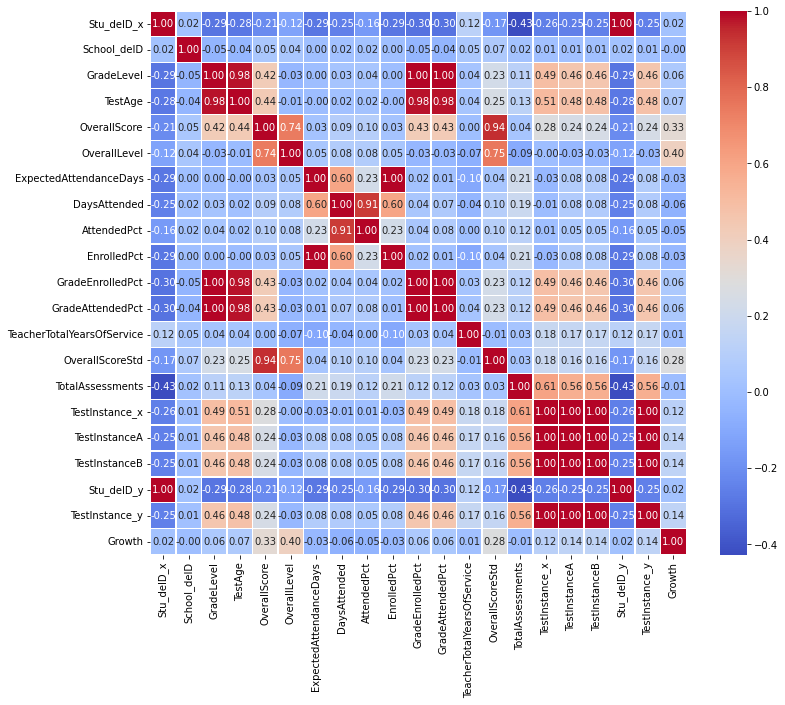

In [74]:
# Correlation Matrix
pearsoncorr = df.corr(method='pearson')

plt.figure(figsize= (12,10))

sns.heatmap(pearsoncorr,
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='coolwarm',
            fmt=".2f",
            annot=True,
            linewidth=0.25)



In [75]:
#Split numerical and categorical dataframes for visualization purpose
#for num_df, only extract the useful columns and drop the columns such as 'Stu_deID'

num_df = df[['School_deID','GradeLevel','TestAge','OverallLevel','ExpectedAttendanceDays','DaysAttended',
           'AttendedPct', 'EnrolledPct' ,'GradeEnrolledPct', 'GradeAttendedPct','TeacherTotalYearsOfService',
           'OverallScoreStd','TotalAssessments']]

#for cat_df, keep only the suitable features for visualization 
cat_df = df[['AcademicYear','StudentGender','StudentEthnicity','Special_Education','Homeless','SocioEconomically','TestDayName',
           'TeacherGender','TeacherEthnicity']]



### **DISTRIBUTION BETWEEN CATEGORICAL VARIABLES**


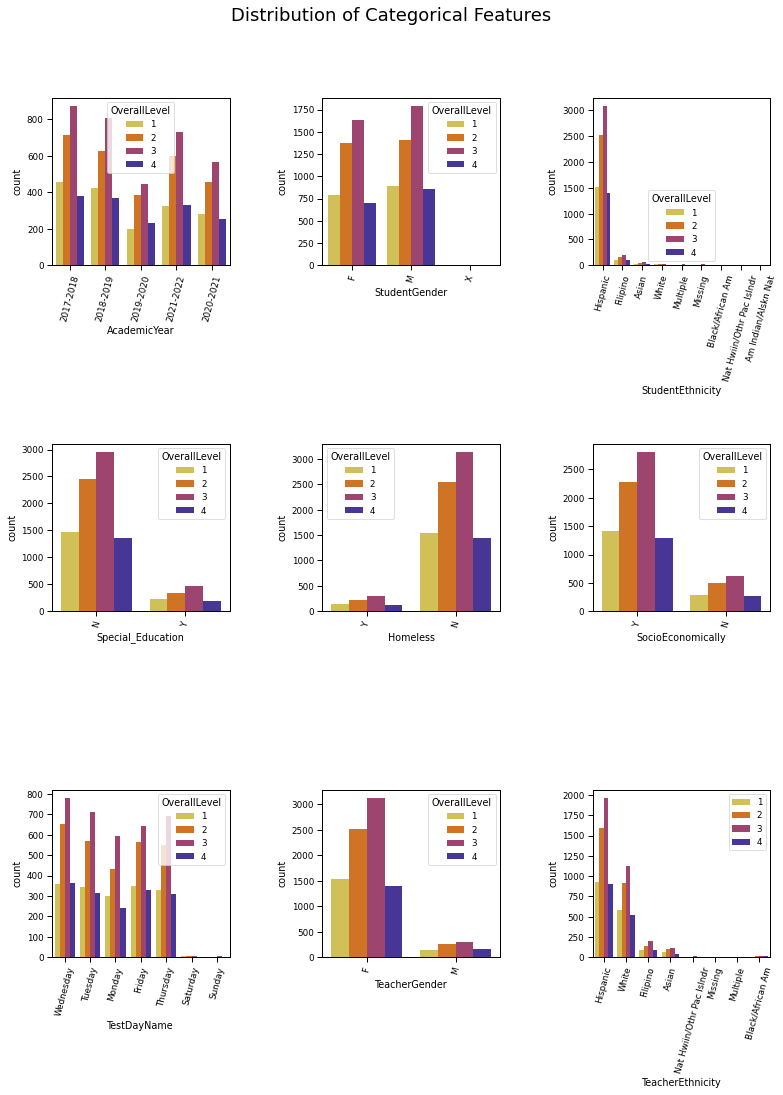

In [123]:
#plot dictribution of categorical values
fig , ax = plt.subplots(3,3, figsize = (12,16))     # set up 2 x 2 frame count plot with figsize 10 x 10
fig.suptitle("Distribution of Categorical Features", fontsize=18)

for i , subplots in zip (cat_df, ax.flatten()):
  g = sns.countplot(cat_df[i],hue = df['OverallLevel'],ax = subplots, palette = 'CMRmap_r')
  g.set_xticklabels(labels=cat_df[i].unique(), rotation= 75)

fig.tight_layout(pad= 5.0)
plt.legend(loc = 'upper right')
plt.show()



### **DISTRIBUTION PLOTS OF NUMERICAL VARIABLES**


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


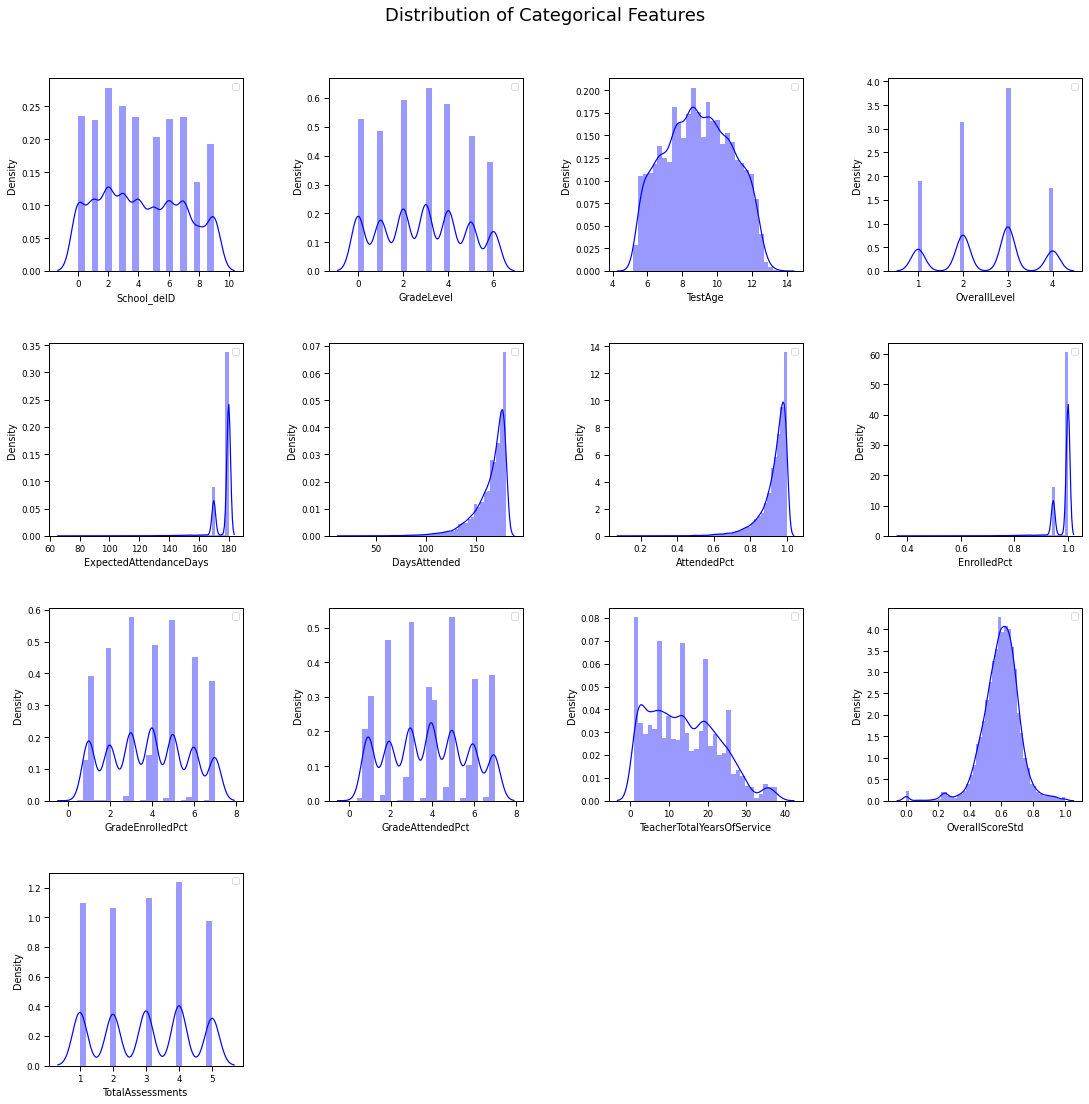

In [124]:
fig , ax = plt.subplots(3,3, figsize = (16,16))     
fig.suptitle("Distribution of Categorical Features", fontsize=18)

for i, column in enumerate(num_df, 1):
    plt.subplot(4, 4, i)
    sns.distplot(x=num_df[column], color = 'blue') 
    plt.legend() 
    plt.xlabel(column)
    fig.tight_layout(pad=4.0)



TotalAssessments    1    2    3    4    5
OverallLevel                             
1                 349  333  324  359  322
2                 489  496  563  655  578
3                 568  641  731  842  649
4                 481  354  323  272  131


<Figure size 432x288 with 0 Axes>

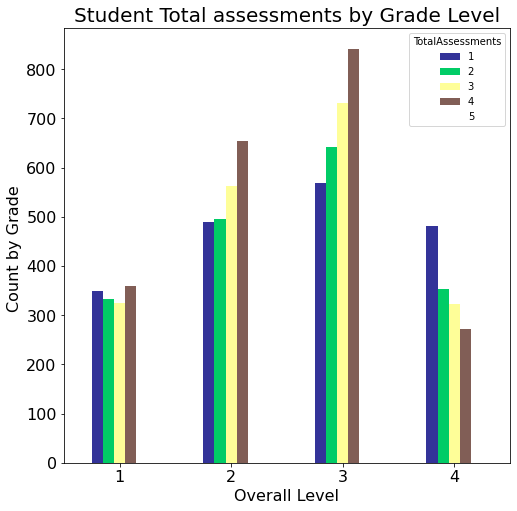

In [79]:
#Crosstab for Student scores by Grade Level
test_assessments = test =  pd.crosstab(index=df.OverallLevel, columns=df.TotalAssessments)
print(test_assessments)
#plot the figure
fig1 = plt.figure()
temp = test_assessments.plot.bar(colormap="terrain", fontsize=16, figsize=(8,8), rot=0) #https://matplotlib.org/stable/tutorials/colors/colormaps.html#sequential
temp = plt.title('Student Total assessments by Grade Level', fontsize=20)
temp = plt.ylabel('Count by Grade ', fontsize=16)
temp = plt.xlabel('Overall Level', fontsize=16)

### **STUDENT SCORES BY GRADE LEVEL**


GradeLevel      0    1    2    3    4    5    6
OverallLevel                                   
1             202  252  160  384  272  167  250
2             480  394  377  537  379  321  293
3             476  369  600  542  622  500  322
4             199  238  395  178  219  220  112


<Figure size 432x288 with 0 Axes>

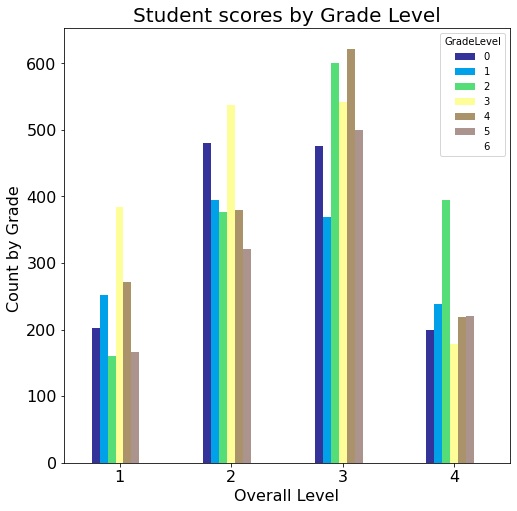

In [80]:
#Crosstab for Student scores by Grade Level
test =  pd.crosstab(index=df.OverallLevel, columns=df.GradeLevel)
print(test)
#plot the figure
fig = plt.figure()
temp = test.plot.bar(colormap="terrain", fontsize=16, figsize=(8,8), rot=0) #https://matplotlib.org/stable/tutorials/colors/colormaps.html#sequential
temp = plt.title('Student scores by Grade Level', fontsize=20)
temp = plt.ylabel('Count by Grade ', fontsize=16)
temp = plt.xlabel('Overall Level', fontsize=16)

# **Feauture Engineering**

### **DISTRIBUTION OF TARGET CLASSES: OVERALLLEVEL**

c:\Users\LUKE-W~1\AppData\Local\R-MINI~1\envs\r-reticulate\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='OverallLevel', ylabel='count'>

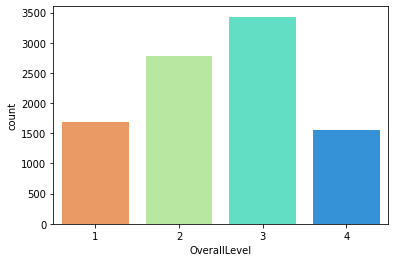

In [82]:
#plot the target variable to observe the class imbalance
fig_szie=(12,8)
sns.countplot(df['OverallLevel'], data = df, palette = 'rainbow_r')


A slight class-imbalance was observed among the scores.

Downsampling will be performed for level 2 and 3 as reference to level 4 count.

A new data balanced dataset named 'bal_df' will be trained with models to see the accuracy performance improvement.


In [86]:
#downsamples level 2 and 3 as reference to level 4
lev_0 = df[df['OverallLevel'] == 0]
lev_1 = df[df['OverallLevel'] == 1]
lev_2 = df[df['OverallLevel'] == 2]
lev_3 = df[df['OverallLevel'] == 3]
lev_4 = df[df['OverallLevel'] == 4]
# resample the levels
lev1_upsample = resample(lev_1,replace=True,n_samples=len(lev_3),random_state=42)
lev2_upsample = resample(lev_2,replace=True,n_samples=len(lev_3),random_state=42)
lev4_upsample = resample(lev_4,replace=True,n_samples=len(lev_3),random_state=42)

c:\Users\LUKE-W~1\AppData\Local\R-MINI~1\envs\r-reticulate\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='OverallLevel', ylabel='count'>

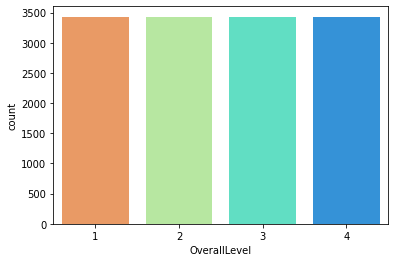

In [87]:
#create a new dataframe with balanced datasets
frames = (lev1_upsample, lev2_upsample, lev_3, lev4_upsample)
bal_df = pd.concat(frames)
fig_szie=(12,8)
sns.countplot(bal_df['OverallLevel'], data = bal_df, palette = 'rainbow_r')


# **FEATURE ENGINEERING TO DO LISTS**

According to the data visualization plots, here are the steps for feature engineering.

GradeEnrolledPct, AttendedPct will be dropped from the data frame to avoid multicollinearity.

TestAge is the student's age on the date of the ELPAC test. For example, for record #1, the student was born on 7/4/2011 and student is 11 year old. TestAge of the student is 6.828340. Since GradeLevel and TestAge are highly correlated and age column was also populated, it's safe to drop the TestAge to avoid multicollinearity.

Other insignificant columns such as 'AcademicYear', 'Stu_deID', 'DOB', 'TestDate' will also be dropped.

Unique value X in 'StudentGender' will be replaced with the mode of each feature column for each train and test data set to avoid data leakage.

Label-encoding will be performed for categorical variables.

Dataset will be split into Train and test dataset.


In [88]:
new_df = df.drop(columns = ['AcademicYear','Stu_deID','DOB','TestAge','GradeEnrolledPct',
                             'AttendedPct','TestDate'])

KeyError: "['Stu_deID'] not found in axis"

In [89]:
##replace X value from StudentGender with Mode value for StudentGender column
print(new_df['StudentGender'].mode())
new_df['StudentGender'] = new_df['StudentGender'].replace(to_replace = 'M', value = 'X') #replace X value with mode

NameError: name 'new_df' is not defined

# **LABEL-ENCODING FOR CATEGORICAL VARIABLES**


In [ ]:
cat_columns = ['StudentGender','StudentEthnicity','Special_Education','Homeless','SocioEconomically',
               'TestDayName','TeacherGender','TeacherEthnicity']

In [ ]:
#Train dataset
label_encoders = {}
for column in cat_columns:
  label_encoders[column] = LabelEncoder()
  new_df[column] = label_encoders[column].fit_transform(new_df[column])

# **Data Dictionary for LabelEncoder values**


In [ ]:
# TeacherEthnicity - description and label encoder value
TeacherEthnicity = pd.concat([df.TeacherEthnicity, new_df.TeacherEthnicity], axis=1)
TeacherEthnicity.columns = ['TeacherEthnicity', 'le']
TeacherEthnicity.value_counts().sort_index()

In [ ]:
# TestDayName - description and label encoder value
TestDayName = pd.concat([df.TestDayName, new_df.TestDayName], axis=1)
TestDayName.columns = ['TestDayName', 'le']
TestDayName.value_counts().sort_index()

In [ ]:
# StudentEthnicity - description and label encoder value
StudentEthnicity = pd.concat([df.StudentEthnicity, new_df.StudentEthnicity], axis=1)
StudentEthnicity.columns = ['StudentEthnicity', 'le']
StudentEthnicity.value_counts().sort_index()

In [ ]:
# TeacherGender - description and label encoder value
TeacherGender = pd.concat([df.TeacherGender, new_df.TeacherGender], axis=1)
TeacherGender.columns = ['TeacherGender', 'le']
TeacherGender.value_counts().sort_index()

In [ ]:
# Special_Education - description and label encoder value
Special_Education = pd.concat([df.Special_Education, new_df.Special_Education], axis=1)
Special_Education.columns = ['Special_Education', 'le']
Special_Education.value_counts().sort_index()

In [ ]:
# # Save a version of the clean file
# new_df.to_csv('/Users/oscargil/Desktop/ADS-599B/Data Folder/new_elpac.csv', encoding='utf-8', index=False)


# **DATA MODELING**

In [90]:
# Import file
df = pd.read_csv('https://raw.githubusercontent.com/OscarG-DataSci/ADS-599B/main/Data%20Folder/new_elpac.csv')
df.head() #check the head

,School_deID,GradeLevel,StudentGender,StudentEthnicity,Special_Education,Homeless,SocioEconomically,TestDayName,OverallScore,OverallLevel,ExpectedAttendanceDays,DaysAttended,EnrolledPct,GradeAttendedPct,TeacherGender,TeacherTotalYearsOfService,TeacherEthnicity,OverallScoreStd,TotalAssessments,TestInstance,Growth
0,3,1,0,4,0,1,1,6,1503,4,180.0,175.0,1.0,1.972222,0,4,3,0.740042,3,1,0
1,3,2,0,4,0,1,1,5,1549,4,180.0,175.0,1.0,2.972222,0,22,3,0.725455,3,2,0
2,3,3,0,4,0,1,1,5,1466,2,180.0,177.0,1.0,3.983333,0,25,3,0.605364,3,3,-2
3,5,4,1,4,0,0,1,0,1535,3,180.0,168.0,1.0,4.933333,0,2,5,0.662651,1,1,0
4,6,3,1,4,0,0,1,6,1412,1,180.0,179.0,1.0,3.994444,0,2,3,0.501916,3,1,0


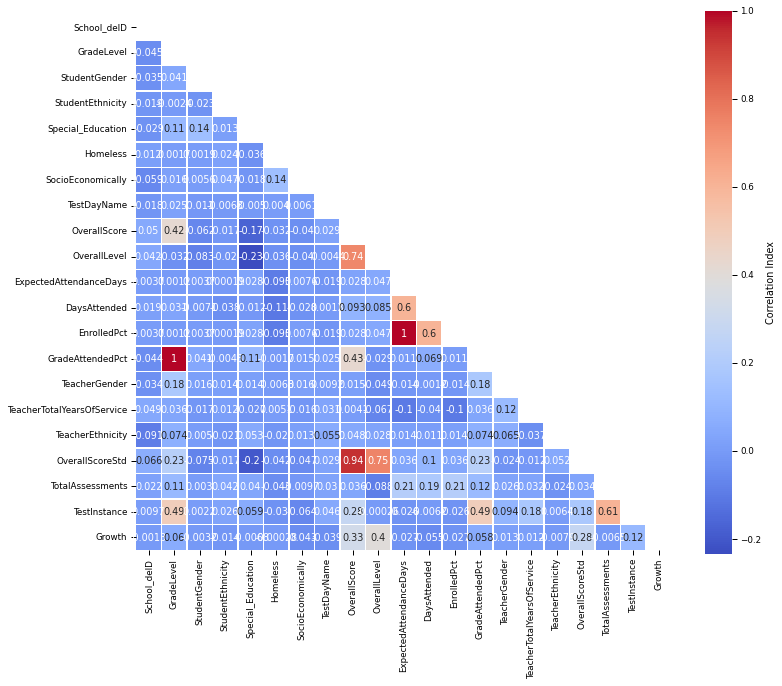

In [91]:
#check for correlations
corr = df.corr()
sns.set_context('paper', font_scale=1)
plt.figure(figsize=(12,10))
plt.tight_layout(pad = 10, w_pad=10, h_pad=10)
matrix = np.triu(corr)
sns.heatmap(df.corr(method='pearson'), annot=True,
linewidths=.5, cmap="coolwarm", mask=matrix,
square = True, cbar_kws={'label':
'Correlation Index'})
plt.show()

In [92]:
#drop highly correlated variable OverallScoreStd
df = df.drop(columns=['OverallScoreStd'])

### **DATA PARTITIONING**

**Split dataset into 70% train and 30% test datasets.**

In [95]:
X = df.loc[ : , df.columns != 'OverallLevel']
y = df[['OverallLevel']]
#split 70% train 30% test
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=700, test_size=0.30)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(6622, 19) (6622, 1) (2838, 19) (2838, 1)


### **Standardized (Scaled) Dataset**
**Train and test dataset were also standardized to test for better performance on trained models.**

In [96]:
#for test purpose create a scaled X and compare the results
X_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled= StandardScaler().fit_transform(X_test)

### **LOGISTIC REGRESSION MODEL (UNSCALED DATA)**


In [97]:
#logistic regression model
logreg = LogisticRegression(random_state=599)
logreg.fit(X_train,y_train)
lg_pred = logreg.predict(X_test)
# print accuracy
logX = logreg.predict(X_train)
print('Train Accuracy:', str(round(accuracy_score(y_train, logX)*100,2)) + '%')
print('Test Accuracy:', str(round(accuracy_score(y_test, lg_pred)*100,2)) +'%')
print('Classification Stats:')
print(classification_report(y_test,lg_pred))

Train Accuracy: 57.08%
Test Accuracy: 57.86%
Classification Stats:
              precision    recall  f1-score   support

           1       0.69      0.62      0.66       517
           2       0.56      0.45      0.50       830
           3       0.54      0.81      0.65      1026
           4       0.66      0.25      0.37       465

    accuracy                           0.58      2838
   macro avg       0.61      0.53      0.54      2838
weighted avg       0.59      0.58      0.56      2838



### **LOGISTIC REGRESSION MODEL (SCALED)**


In [98]:
#scaled logistic regression

logreg_Scale = LogisticRegression(random_state=599)
logreg_Scale.fit(X_scaled,y_train)
#evaluate on train data
trainX = logreg_Scale.predict(X_scaled)
print('Train Accuracy:', str(round(accuracy_score(y_train, trainX)*100,2)) + '%')
lg_pred_scaled = logreg_Scale.predict(X_test_scaled)
#check the accuracy
print('Test Accuracy:', str(round(accuracy_score(y_test, lg_pred_scaled)*100,2))+'%')
print('Test Classification Stats:')
print(classification_report(y_test,lg_pred_scaled))



Train Accuracy: 85.05%
Test Accuracy: 84.57%
Test Classification Stats:
              precision    recall  f1-score   support

           1       0.92      0.89      0.90       517
           2       0.83      0.85      0.84       830
           3       0.82      0.85      0.84      1026
           4       0.86      0.78      0.82       465

    accuracy                           0.85      2838
   macro avg       0.86      0.84      0.85      2838
weighted avg       0.85      0.85      0.85      2838



Since accuracy for LG model with scaled dataset is better, we will do hyperparameter tuning on the scaled dataset.


### **PENALIZED LOGISTIC REGRESSION MODEL (SCALED)**


In [99]:
#Penalized logistic regression

logpen = LogisticRegression(penalty ='l2',
solver = 'newton-cg', random_state=599) 
logpenn=logpen.fit(X_scaled,y_train)
#evaluate on train data
trainX1 = logpen.predict(X_scaled)
print('Train Accuracy:', str(round(accuracy_score(y_train, trainX1)*100,2))+'%')
lg_pred_pen = logpen.predict(X_test_scaled)
#check the accuracy
print('Test Accuracy:', str(round(accuracy_score(y_test, lg_pred_pen)*100,2))+'%')
print('Test Classification Stats:')
print(classification_report(y_test,lg_pred_pen))

Train Accuracy: 85.03%
Test Accuracy: 84.57%
Test Classification Stats:
              precision    recall  f1-score   support

           1       0.92      0.89      0.90       517
           2       0.83      0.85      0.84       830
           3       0.82      0.85      0.84      1026
           4       0.86      0.78      0.82       465

    accuracy                           0.85      2838
   macro avg       0.86      0.84      0.85      2838
weighted avg       0.85      0.85      0.85      2838



### **TUNED LOGISTIC REGRESSION MODEL**


In [100]:
# setting the parameter grid
param_grid = {'solver': ['newton-cg', 'saga'], 
                   'penalty': ['l1', 'l2', 'elasticnet'],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# perform hyperparameter tuning
print("# Tuning hyper-parameters for accuracy\n")
tuned_log = GridSearchCV(LogisticRegression(random_state=599),param_grid, cv=5, scoring='accuracy') 
tuned_log.fit(X_scaled,y_train)
# view accuracy scores for all the models
print("Grid scores for all the Logistic Regression Model based on CV:\n")
means = tuned_log.cv_results_['mean_test_score']
stds = tuned_log.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, tuned_log.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
# check out best model performance
print("\nBest parameters set found on training set:", tuned_log.best_params_)
print("Best model test accuracy:", tuned_log.best_score_)

log_best = tuned_log.best_estimator_
tuned_log_y_pred = log_best.predict(X_test_scaled)

print('\n\nTuned Model Stats:')
print('Test Classification Stats:')
print(classification_report(y_test,tuned_log_y_pred))



# Tuning hyper-parameters for accuracy

Grid scores for all the Logistic Regression Model based on CV:

nan (+/-nan) for {'C': 0.001, 'penalty': 'l1', 'solver': 'newton-cg'}
0.36922 (+/-0.00319) for {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}
0.56176 (+/-0.00846) for {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
0.56176 (+/-0.00846) for {'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}
nan (+/-nan) for {'C': 0.001, 'penalty': 'elasticnet', 'solver': 'newton-cg'}
nan (+/-nan) for {'C': 0.001, 'penalty': 'elasticnet', 'solver': 'saga'}
nan (+/-nan) for {'C': 0.01, 'penalty': 'l1', 'solver': 'newton-cg'}
0.79780 (+/-0.02408) for {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
0.77998 (+/-0.01614) for {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.77998 (+/-0.01614) for {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
nan (+/-nan) for {'C': 0.01, 'penalty': 'elasticnet', 'solver': 'newton-cg'}
nan (+/-nan) for {'C': 0.01, 'penalty': 'elasticnet', 'solver': 'saga'}
nan (+/-nan)

### **K-NEAREST NEIGHBORS (KNN)**


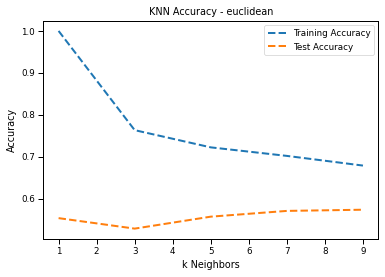

metric: euclidean


k values,Training Accuracy,Test Accuracy
1,1,0.553206
3,0.763214,0.528189
5,0.722138,0.55673
7,0.701752,0.570472
9,0.678647,0.573291


In [101]:
metric='euclidean'
knn_accuracy = []

for i in range(1, 10, 2):
    knn_clsf = KNeighborsClassifier(metric=metric, n_neighbors=i).fit(X_scaled, y_train)

    knn_clsf_train_pred = knn_clsf.predict(X_scaled)
    knn_clsf_test_pred  = knn_clsf.predict(X_test_scaled)

    knn_accuracy.append({'k values': i,
                         'Training Accuracy': accuracy_score(knn_clsf_train_pred, y_train),
                         'Test Accuracy': accuracy_score(knn_clsf_test_pred, y_test)})

# Plot
print("\n")
plt.plot(pd.DataFrame(knn_accuracy)['k values'], pd.DataFrame(knn_accuracy)['Training Accuracy'], '--', linewidth=2, label='Training Accuracy')
plt.plot(pd.DataFrame(knn_accuracy)['k values'], pd.DataFrame(knn_accuracy)['Test Accuracy'], '--', linewidth=2, label='Test Accuracy')
plt.xlabel('k Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy - ' + metric)
plt.legend()
plt.show()

# Results
print("metric:", metric)
pd.DataFrame(knn_accuracy).style.hide_index()

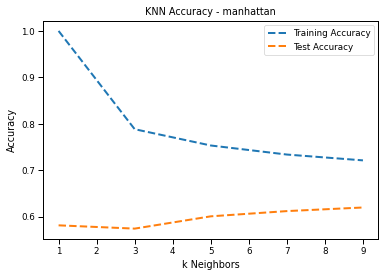

metric: manhattan


k values,Training Accuracy,Test Accuracy
1,1,0.581748
3,0.788584,0.5747
5,0.753549,0.601128
7,0.734068,0.612403
9,0.721534,0.620155


In [102]:
metric='manhattan'
knn_accuracy = []

for i in range(1, 10, 2):
    knn_clsf = KNeighborsClassifier(metric=metric, n_neighbors=i).fit(X_scaled, y_train)

    knn_clsf_train_pred = knn_clsf.predict(X_scaled)
    knn_clsf_test_pred  = knn_clsf.predict(X_test_scaled)

    knn_accuracy.append({'k values': i,
                         'Training Accuracy': accuracy_score(knn_clsf_train_pred, y_train),
                         'Test Accuracy': accuracy_score(knn_clsf_test_pred, y_test)})

# Plot
print("\n")
plt.plot(pd.DataFrame(knn_accuracy)['k values'], pd.DataFrame(knn_accuracy)['Training Accuracy'], '--', linewidth=2, label='Training Accuracy')
plt.plot(pd.DataFrame(knn_accuracy)['k values'], pd.DataFrame(knn_accuracy)['Test Accuracy'], '--', linewidth=2, label='Test Accuracy')
plt.xlabel('k Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy - ' + metric)
plt.legend()
plt.show()

# Results
print("metric:", metric)
pd.DataFrame(knn_accuracy).style.hide_index()

With elbow method, k=5 is the optimal k. Manhattan distance's accuracy at k=5 is 0.60 for the test dataset and outperform over Euclidean. Thus, we will train our model with Manhattan distance.

In [103]:
knn_classifier = KNeighborsClassifier(metric='manhattan', n_neighbors=5)

knn_classifier.fit(X_scaled, y_train)

knn_test_pred = knn_classifier.predict(X_test_scaled)
knn_train_pred = knn_classifier.predict(X_scaled)

print('''Metric: Manhattan
Neighbors: 5''')
print('Train Accuracy:', str(round(accuracy_score(y_train, knn_train_pred)*100,2))+ '%')
print('Test Accuracy: ', str(round(accuracy_score(y_test, knn_test_pred)*100,2))+ '%')
print("\n")
print(classification_report(y_test,knn_test_pred))

Metric: Manhattan
Neighbors: 5
Train Accuracy: 75.35%
Test Accuracy:  60.11%


              precision    recall  f1-score   support

           1       0.68      0.60      0.63       517
           2       0.50      0.56      0.53       830
           3       0.60      0.68      0.64      1026
           4       0.80      0.50      0.62       465

    accuracy                           0.60      2838
   macro avg       0.65      0.58      0.60      2838
weighted avg       0.62      0.60      0.60      2838



### **DECISION TREE**


In [104]:
dtc_clf = DecisionTreeClassifier(criterion="gini",max_depth=5).fit(X,y)

dtc_test_pred = dtc_clf.predict(X_test)
dtc_train_pred = dtc_clf.predict(X_train)

print('Train Accuracy:', str(round(accuracy_score(y_train, dtc_train_pred)*100,2))+ '%')
print('Test Accuracy: ', str(round(accuracy_score(y_test, dtc_test_pred)*100,2))+ '%')
print("\n")
print(classification_report(y_test,dtc_test_pred))

Train Accuracy: 82.3%
Test Accuracy:  82.7%


              precision    recall  f1-score   support

           1       0.87      0.94      0.90       517
           2       0.88      0.65      0.74       830
           3       0.75      0.95      0.83      1026
           4       0.96      0.76      0.85       465

    accuracy                           0.83      2838
   macro avg       0.86      0.82      0.83      2838
weighted avg       0.84      0.83      0.82      2838



### **RANDOM FOREST**


In [107]:
#random forests
train_errors = list()
test_errors = list()

for i in range(1,50):
  rf_model = RandomForestClassifier(max_depth=i)    #Create multiple models here each based on the i variable above
  rf_model.fit(X_train,y_train)
  train_pred = rf_model.predict(X_train)
  test_pred = rf_model.predict(X_test)
  train_errors.append(accuracy_score(y_train,train_pred))    # Store the result of modes in t_train_erors and t_test_errors variables
  test_errors.append(accuracy_score(y_test, test_pred))

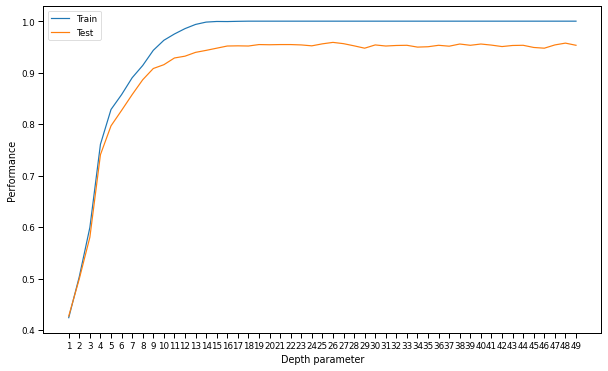

In [108]:
# Plot of test and training errors
fig,ax = plt.subplots(figsize=(10,6))
plt.plot(range(1,50),train_errors, label='Train')
plt.plot(range(1,50),test_errors, label='Test')
plt.legend(loc='upper left')
plt.xlabel('Depth parameter')
plt.ylabel('Performance')
plt.xticks(ticks =np.arange(1, 50, 1));



In [109]:
#plot random forest using optimal depth
tuned_rf= RandomForestClassifier(max_depth=13, class_weight = 'balanced')
tuned_rf.fit(X_train,y_train)

rf_test_pred = tuned_rf.predict(X_test)
rf_train_pred = tuned_rf.predict(X_train)

print('Train Accuracy:', str(round(accuracy_score(y_train, rf_train_pred)*100,2))+ '%')
print('Test Accuracy: ', str(round(accuracy_score(y_test, rf_test_pred)*100,2))+ '%')
print("\n")
print(classification_report(y_test,rf_test_pred))



Train Accuracy: 99.59%
Test Accuracy:  94.96%


              precision    recall  f1-score   support

           1       0.99      0.95      0.97       517
           2       0.93      0.96      0.94       830
           3       0.94      0.95      0.95      1026
           4       0.97      0.93      0.95       465

    accuracy                           0.95      2838
   macro avg       0.96      0.95      0.95      2838
weighted avg       0.95      0.95      0.95      2838



### **GRADIENT BOOSTING CLASSIFIER**


In [110]:
#base gradient boosting model
gbc = GradientBoostingClassifier(random_state=599)
gbc.fit(X_train, y_train)
gbc.fit(X_train,y_train)
gbc_pred = gbc.predict(X_test)
# print accuracy
gbcX = gbc.predict(X_train)
print('Train Accuracy:', str(round(accuracy_score(y_train, gbcX)*100,2)) +'%')
print('Test Accuracy:', str(round(accuracy_score(y_test, gbc_pred)*100,2))+ '%')
print('Classification Stats:')
print(classification_report(y_test,gbc_pred))

Train Accuracy: 97.51%
Test Accuracy: 96.72%
Classification Stats:
              precision    recall  f1-score   support

           1       0.99      0.97      0.98       517
           2       0.96      0.98      0.97       830
           3       0.96      0.97      0.96      1026
           4       0.98      0.93      0.95       465

    accuracy                           0.97      2838
   macro avg       0.97      0.96      0.97      2838
weighted avg       0.97      0.97      0.97      2838



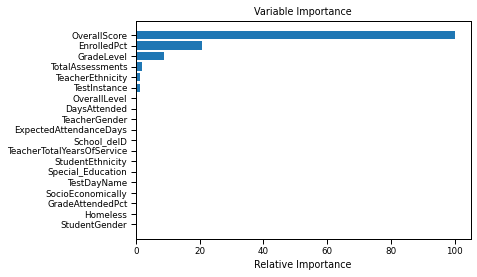

In [111]:
# gbc.feature_importances_
feature_importance = gbc.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos        = np.arange(sorted_idx.shape[0]) + .5

plt.barh(pos, feature_importance[sorted_idx], align='center');
plt.yticks(pos, df.columns[sorted_idx]);
plt.xlabel('Relative Importance');
plt.title('Variable Importance');

### **GBC WITH ONLY THE TOP 6 IMPORTANT FEATURES**


In [112]:
small_train = X_train[['OverallScore','EnrolledPct','GradeLevel','TotalAssessments','TeacherEthnicity','TestInstance']].copy()
small_test = X_test[['OverallScore', 'EnrolledPct','GradeLevel','TotalAssessments','TeacherEthnicity','TestInstance']].copy()

In [113]:
#base gradient boosting model
s_gbc = GradientBoostingClassifier(random_state=599)
s_gbc.fit(small_train, y_train)
s_gbc.fit(small_train,y_train)
s_gbc_pred = s_gbc.predict(small_test)
# print accuracy
s_gbcX = s_gbc.predict(small_train)
print('Train Accuracy:', str(round(accuracy_score(y_train, s_gbcX)*100,2)) +'%')
print('Test Accuracy:', str(round(accuracy_score(y_test, s_gbc_pred)*100,2)) +'%')
print('Classification Stats:')
print(classification_report(y_test,s_gbc_pred))

Train Accuracy: 97.25%
Test Accuracy: 96.93%
Classification Stats:
              precision    recall  f1-score   support

           1       0.99      0.98      0.98       517
           2       0.97      0.97      0.97       830
           3       0.96      0.98      0.97      1026
           4       0.99      0.93      0.96       465

    accuracy                           0.97      2838
   macro avg       0.97      0.97      0.97      2838
weighted avg       0.97      0.97      0.97      2838



### **HISTOGRADIENT BOOSTING CLASSIFIER (HGB) WITH ALL VARIABLES**


In [114]:
hgb = HistGradientBoostingClassifier(random_state=599)
hgb.fit(X_train, y_train)
hgb_pred = hgb.predict(X_test)
# print accuracy
hgbX = hgb.predict(X_train)
print('Train Accuracy:', str(round(accuracy_score(y_train, hgbX)*100,2))+ '%')
print('Test Accuracy:', str(round(accuracy_score(y_test, hgb_pred)*100,2))+ '%')
print('Classification Stats:')
print(classification_report(y_test,hgb_pred))

Train Accuracy: 100.0%
Test Accuracy: 97.46%
Classification Stats:
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       517
           2       0.97      0.98      0.98       830
           3       0.97      0.98      0.97      1026
           4       0.98      0.95      0.96       465

    accuracy                           0.97      2838
   macro avg       0.98      0.97      0.97      2838
weighted avg       0.97      0.97      0.97      2838



For the purpose of creating the web app, we want to simplify the app using only the partial variables including only most of student's information for better convenience.
For example, if the model included 'TeachYearsofService', one will have to investigate more on teacher's information. Thus, we will only use the School ID and student's information to train HGB as 'HGB_Partial'. If the accuracy is still optimal above 90%, then we will use 'HGB_Partial' for creating a streamlit webapp.

In [115]:
Xs_train = X_train.drop(columns = ['TotalAssessments','TestInstance','Growth','TeacherGender','TeacherTotalYearsOfService'])
Xs_test = X_test.drop(columns = ['TotalAssessments','TestInstance','Growth','TeacherGender','TeacherTotalYearsOfService'])


In [116]:
small_hgb = HistGradientBoostingClassifier(random_state=200)
small_hgb.fit(Xs_train, y_train)
small_hgb_pred = small_hgb.predict(Xs_test)
# print accuracy
small_hgbX = small_hgb.predict(Xs_train)
print('Train Accuracy:', str(round(accuracy_score(y_train, small_hgbX)*100,2))+ '%')
print('Test Accuracy:', str(round(accuracy_score(y_test, small_hgb_pred)*100,2))+ '%')
print('Classification Stats:')
print(classification_report(y_test,small_hgb_pred))

Train Accuracy: 99.92%
Test Accuracy: 92.92%
Classification Stats:
              precision    recall  f1-score   support

           1       0.99      0.97      0.98       517
           2       0.93      0.97      0.95       830
           3       0.91      0.91      0.91      1026
           4       0.90      0.86      0.88       465

    accuracy                           0.93      2838
   macro avg       0.93      0.93      0.93      2838
weighted avg       0.93      0.93      0.93      2838



### **PERFORMANCE METRICS OF ALL TRAINED MODELS**

In [118]:
labels = [1,2,3,4]
target_names = ['Level_1','Level_2','Level_3','Level_4']

models = [lg_pred, lg_pred_scaled, lg_pred_pen, tuned_log_y_pred, knn_test_pred, dtc_test_pred, rf_test_pred, gbc_pred, s_gbc_pred,
          hgb_pred, small_hgb_pred]
scores_table = []
accuracy = []

for i in models: 
  accuracy_scores = accuracy_score(i, y_test)
  f1_scores = f1_score(i, y_test, average = None)
  f1_scores_with_labels = {label:score for label,score in zip(target_names, f1_scores*100)}
  scores_table.append(f1_scores_with_labels)
  accuracy.append(accuracy_scores*100)

### **ACCURACY**


In [119]:
# merge accuracy and f1_scores dataframe
accuracy = pd.DataFrame(accuracy, columns = ['Accuracy_score'])
accuracy_table = accuracy.round(decimals = 2)

accuracy_table.insert(0, 'Models', ['LG','LG_SCALED','PENALIZED_LG_SCALED','TUNED_LG','KNN','DECISION_TREE','RANDOM_FOREST','GBC', 'GBC_FEAT',
                              'HGB_FULL','HGB_PARTIAL'])
accuracy_table


,Models,Accuracy_score
0,LG,57.86
1,LG_SCALED,84.57
2,PENALIZED_LG_SCALED,84.57
3,TUNED_LG,84.43
4,KNN,60.11
5,DECISION_TREE,82.70
6,RANDOM_FOREST,94.96
7,GBC,96.72
8,GBC_FEAT,96.93
9,HGB_FULL,97.46


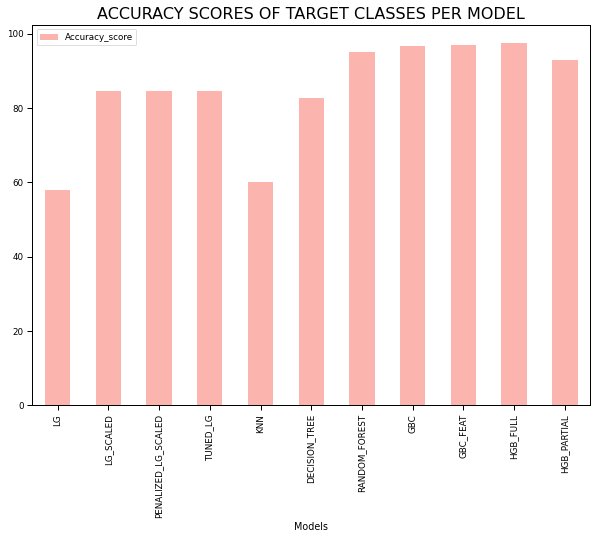

In [120]:
#Bargraph for Comparison of Accuracy for Each Model

accuracy_table.plot(x="Models", y= ['Accuracy_score'], kind = 'bar',figsize = (10,7), colormap = 'Pastel1')
plt.title('ACCURACY SCORES OF TARGET CLASSES PER MODEL', size = 16)
plt.show()

### **F1 SCORES**


In [121]:
f1_scores = pd.DataFrame(scores_table)
f1_table = f1_scores.round(decimals = 2)

#insert models names
f1_table.insert(0, 'Models', ['LG','LG_SCALED','PENALIZED_LG_SCALED','TUNED_LG','KNN','DECISION_TREE','RANDOM_FOREST','GBC','GBC_FEAT',
                              'HGB_FULL','HGB_PARTIAL'])
pd.DataFrame(f1_table)
f1_table

,Models,Level_1,Level_2,Level_3,Level_4
0,LG,65.58,49.97,64.94,36.65
1,LG_SCALED,90.16,83.64,83.84,81.62
2,PENALIZED_LG_SCALED,90.16,83.64,83.84,81.62
3,TUNED_LG,90.11,83.51,83.69,81.35
4,KNN,63.44,53.10,63.72,61.72
5,DECISION_TREE,90.05,74.48,83.49,85.23
6,RANDOM_FOREST,96.84,94.38,94.62,94.73
7,GBC,98.14,97.08,96.42,95.15
8,GBC_FEAT,98.25,97.06,96.68,95.80
9,HGB_FULL,98.84,97.84,97.09,96.07


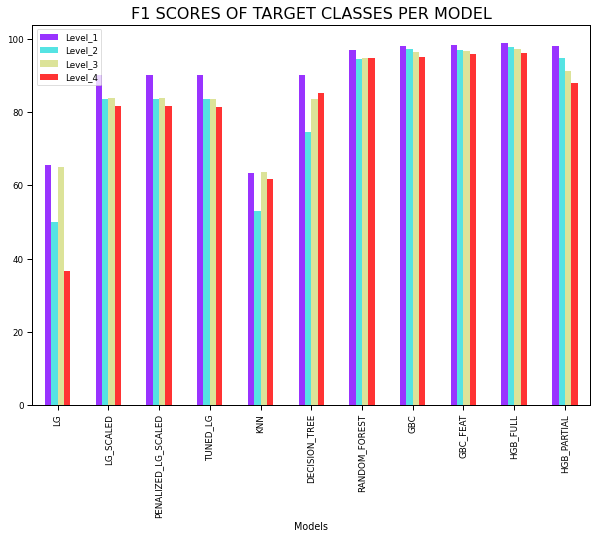

In [122]:
#Bargraph for Comparison of Metrics for Each Model

f1_table.plot(x='Models', y= ['Level_1','Level_2','Level_3','Level_4'], kind = 'bar',
               figsize = (10,7), colormap = 'rainbow', alpha = 0.8)
plt.title('F1 SCORES OF TARGET CLASSES PER MODEL', size = 16)
plt.show()